For this worksheet, we'll need to install the pandas package. Run the cell below, or run ```pip install pandas``` in the terminal/command-line/command prompt.

In [1]:
!pip install pandas

You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Worksheet 3: Pandas

Pandas is a python package for data analysis. Where numpy is a package built around a the data structure of a _matrix_, pandas is a package built around the data structure of a _dataframe_. A _dataframe_ is a lot like a matrix, with some key differences:

* In a data frame, the columns have header names. 
* Different datatypes (int, string, boolean) are allowed within the same dataframe. Each column has its own datatype

In short, dataframes represent datasets of the kind we've seen in the lectures: an instance per row, and a feature per column. 

Pandas is designed to work together with numpy and matplotlib. Let's import all of them

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

To explore Pandas we'll import the ANSUR II dataset (we also used this to create the examples in the first lecture). ANSUR II is an _anthropometric_ dataset: it contains body measurements. ANSUR II contains 108 measurements for about 4000 men and about 2000 women (all US soldiers).

We'll start by reading the data. Linke numpy, pandas has a function for reading CSV files. Pandas' function is much more robust, and much less likely to give you trouble. It does come with [a lot of options](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html), so you may have to try a few things before you get it to read your data accurately.

ANSUR II comes in two separate tables: one for male soldiers, and one for female soldiers:

In [4]:
female = pd.read_csv('./ansur/ANSUR II FEMALE Public.csv')
male = pd.read_csv('./ansur/ANSUR II MALE Public.csv')

```male``` and ```female``` are pandas DataFrame objects. Jupyter notebooks will print these as tables:

In [5]:
male

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10027,266,1467,337,222,1347,253,202,401,369,...,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,10032,233,1395,326,220,1293,245,193,394,338,...,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand
2,10033,287,1430,341,230,1327,256,196,427,408,...,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand
3,10092,234,1347,310,230,1239,262,199,401,359,...,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand
4,10093,250,1585,372,247,1478,267,224,435,356,...,Combat Service Support,92G,North Carolina,2,NaN,2,21,77,213,Right hand
5,10115,263,1407,344,216,1293,228,184,404,340,...,Combat Service Support,91L,Kentucky,1,NaN,1,39,69,175,Right hand
6,10117,314,1476,343,257,1378,280,207,453,452,...,Combat Service Support,91D,Mississippi,2,NaN,2,32,72,250,Right hand
7,10237,304,1529,360,254,1402,247,206,425,332,...,Combat Service Support,88M,Romania,1,NaN,1,23,74,211,Right hand
8,10242,321,1457,339,230,1345,257,198,415,379,...,Combat Service Support,92F,Arkansas,1,NaN,1,36,70,220,Right hand
9,10244,227,1481,345,233,1372,264,204,406,325,...,Combat Support,25L,Maryland,1,NaN,1,23,72,160,Left hand


These are big dataframes. Pandas can give us some quick summary statistics per column very easily.

In [6]:
male.describe()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,SubjectNumericRace,DODRace,Age,Heightin,Weightlbs
count,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,...,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000
mean,20003.370897,254.650906,1440.736894,335.244488,229.343949,1329.082068,252.017148,200.935081,415.675649,358.135718,...,387.642822,1056.485301,855.239588,175.916707,847.511514,8.973542,1.534052,30.158991,70.035767,188.004900
std,6568.435122,37.327178,63.287242,17.482795,14.649102,59.516123,12.936131,10.470947,19.161654,34.618093,...,29.349007,52.154671,142.206992,8.955055,41.655628,83.012638,0.958815,8.810118,2.947419,29.941869
min,10027.000000,163.000000,1194.000000,270.000000,156.000000,1106.000000,186.000000,156.000000,337.000000,246.000000,...,293.000000,876.000000,393.000000,141.000000,695.000000,1.000000,1.000000,17.000000,60.000000,0.000000
25%,14270.250000,227.000000,1398.000000,324.000000,219.250000,1289.000000,243.000000,194.000000,403.000000,335.000000,...,367.000000,1020.000000,756.000000,170.000000,819.000000,1.000000,1.000000,23.000000,68.000000,168.000000
50%,17236.500000,251.000000,1439.000000,335.000000,228.000000,1328.000000,252.000000,201.000000,415.000000,357.000000,...,386.000000,1055.000000,846.000000,176.000000,847.000000,1.000000,1.000000,28.000000,70.000000,185.000000
75%,27315.750000,279.000000,1481.000000,346.000000,239.000000,1367.000000,261.000000,208.000000,428.000000,380.000000,...,407.000000,1090.000000,944.000000,182.000000,875.000000,2.000000,2.000000,36.000000,72.000000,207.000000
max,29452.000000,451.000000,1683.000000,393.000000,293.000000,1553.000000,306.000000,245.000000,489.000000,490.000000,...,494.000000,1245.000000,1442.000000,216.000000,1009.000000,4251.000000,8.000000,58.000000,94.000000,321.000000



In pandas these columns are called _Series_, and a dataframe is basically a list of Series objects with the same length (indexed in various ways for efficient access).

Let's have a look at all the available measurements.

In [8]:
for col in female.columns:
    print(col)

SubjectId
abdominalextensiondepthsitting
acromialheight
acromionradialelength
anklecircumference
axillaheight
balloffootcircumference
balloffootlength
biacromialbreadth
bicepscircumferenceflexed
bicristalbreadth
bideltoidbreadth
bimalleolarbreadth
bitragionchinarc
bitragionsubmandibulararc
bizygomaticbreadth
buttockcircumference
buttockdepth
buttockheight
buttockkneelength
buttockpopliteallength
calfcircumference
cervicaleheight
chestbreadth
chestcircumference
chestdepth
chestheight
crotchheight
crotchlengthomphalion
crotchlengthposterioromphalion
earbreadth
earlength
earprotrusion
elbowrestheight
eyeheightsitting
footbreadthhorizontal
footlength
forearmcenterofgriplength
forearmcircumferenceflexed
forearmforearmbreadth
forearmhandlength
functionalleglength
handbreadth
handcircumference
handlength
headbreadth
headcircumference
headlength
heelanklecircumference
heelbreadth
hipbreadth
hipbreadthsitting
iliocristaleheight
interpupillarybreadth
interscyei
interscyeii
kneeheightmidpatella
k

Each column name with a lowercase letter represents a physical measurement. Some of these are quite technical (like _bizygomaticbreadth_). The dataset comes with a very helpful document that shows what each measurement means (and how it should be performed). It's [included with the worksheets](./ansur/Hotzman_2011_ANSURIII_Measurements_a548497.pdf). Scroll down to section 6.4 for the description of the measurements.

Once the dataframe is loaded, you can refer to the columns by name as python objects. For instance:

In [9]:
male.stature

0       1776
1       1702
2       1735
3       1655
4       1914
5       1720
6       1810
7       1850
8       1777
9       1811
10      1780
11      1733
12      1814
13      1861
14      1709
15      1740
16      1694
17      1766
18      1748
19      1794
20      1780
21      1680
22      1653
23      1959
24      1755
25      1630
26      1825
27      1795
28      1745
29      1818
        ... 
4052    1700
4053    1780
4054    1758
4055    1818
4056    1703
4057    1706
4058    1726
4059    1763
4060    1652
4061    1805
4062    1874
4063    1816
4064    1740
4065    1681
4066    1655
4067    1763
4068    1746
4069    1733
4070    1757
4071    1567
4072    1703
4073    1718
4074    1871
4075    1728
4076    1788
4077    1688
4078    1765
4079    1690
4080    1718
4081    1828
Name: stature, Length: 4082, dtype: int64

Jupyter notebooks even gives you dynamic autocomplete. Try putting your cursor at the end of the next line and pressing the ```TAB``` button on your keyboard.

In [ ]:
female.

We can now easily do scatterplots of different measurements. Let's plot the ```stature``` (height) against the ```span``` (distance between outstretched arms).

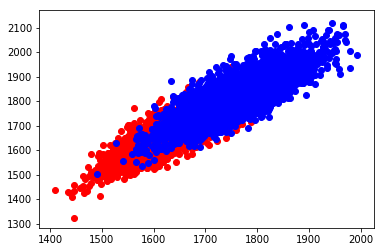

In [10]:
plt.scatter(female.stature, female.span, color='red')
plt.scatter(male.stature, male.span, color='blue');

Even if we make the points transparent (```alpha=0.1```) and small (```s=1```), it's quite a dense cloud. We can easily select a small subset by [slicing](https://www.pythoncentral.io/how-to-slice-listsarrays-and-tuples-in-python/):

In [11]:
male[:3]

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10027,266,1467,337,222,1347,253,202,401,369,...,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,10032,233,1395,326,220,1293,245,193,394,338,...,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand
2,10033,287,1430,341,230,1327,256,196,427,408,...,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand


Note that slicing like this only works over the rows. We can't do ```male[:3, 5:12]```, like we could in numpy.

For now, we know enough to plot a small subset of the data.

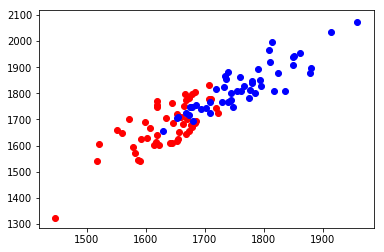

In [12]:
female_sub = female[:50]
male_sub = male[:50]

plt.scatter(female_sub.stature, female_sub.span, color='red')
plt.scatter(male_sub.stature, male_sub.span, color='blue');

To select a set of columns, the best method is to pass a list of strings containing column names. The result is another dataframe.

In [13]:
male[['bicepscircumferenceflexed', 'Age']]

,bicepscircumferenceflexed,Age
0,369,41
1,338,35
2,408,42
3,359,31
4,356,21
5,340,39
6,452,32
7,332,23
8,379,36
9,325,23


### Simple arithmetic

Like numpy, pandas objects overload basic arithmetic operations. For instance, the units in this dataset are in millimeters, which is a little hard to read. To convert them to meters, we can simply multiply by 0.001.


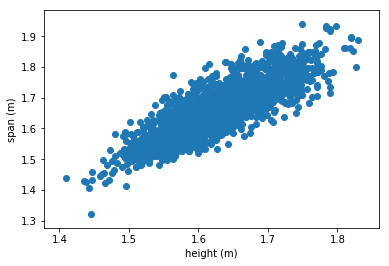

In [14]:
stat = female.stature * 0.001
span = female.span * 0.001

plt.scatter(stat, span);

plt.xlabel('height (m)')
plt.ylabel('span (m)');

### Descriptive statistics

For most descriptive statistics, pandas provides member functions:

In [15]:
print('mean           ', female.stature.mean())
print('std dev.       ', female.stature.std())
print('median         ', female.stature.median())
print('standard error ', female.stature.sem())

mean            1628.4733131923465
std dev.        64.19951224968793
median          1626.0
standard error  1.4405956746546726


### Concatenating and sampling

To perform the classification task from the first lecture (predicting gender from physical measurements), we want the male and female data in a single dataframe. To accomplish this, we can concatenate the two dataframes

In [16]:
people = pd.concat([male, female])

/Users/Peter/anaconda/envs/pytorch4/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


This gives us a dataset of all the male measurements first, and then all the female measurements. For many reasons, it's helpful to shuffle these, so that the order is random. The simplest way to do this is pandas is to _sample_ a new dataframe (without replacement) of the same size:

In [17]:
people = people.sample(frac=1)
people[:5].Gender

627     Female
1550      Male
1822    Female
59      Female
1501      Male
Name: Gender, dtype: object

Note that the row indices from the original dataframe are retained and shuffled as well. For our purposes this doesn't matter.

## Performing Classification

### Categories and codes

To perform classification on this dataset, we need to convert the target value (people.Gender) from strings to categorical data. Right now, pandas thinks the column can have any string value: when we convert it, it checks the existing values (Male, Female) and limits the column values to those two options (changing the datatype).

In [18]:
gender_cat = people.Gender.astype('category')
print(gender_cat.dtype)
print(gender_cat.cat.categories)

category
Index(['Female', 'Male'], dtype='object')


Note that we haven't changed the original data. To insert the categorized column back into the original dataframe, we just re-assign it.

In [19]:
people.Gender = people.Gender.astype('category')

For many tasks (including classification with sklearn), we need integers instead of categorical values. Pandas actually uses integer codes behind the scenes for its categories and it's a simple matter to get a column of integers from a column of categorical data:

In [20]:
people.Gender.cat.codes

627     0
1550    1
1822    0
59      0
1501    1
804     1
1864    1
1862    0
1844    1
2006    1
184     0
608     1
1670    0
2471    1
3036    1
651     1
968     1
1660    1
3225    1
2228    1
1595    0
572     1
1826    0
1545    0
255     0
1834    0
615     1
1749    1
3271    1
1896    0
       ..
1045    0
529     0
776     0
1100    0
677     0
850     0
1370    0
2087    1
1844    0
1890    1
3053    1
922     1
2024    1
3947    1
833     0
655     0
1724    0
1342    0
2799    1
2590    1
3650    1
2534    1
3934    1
1289    1
1099    1
1071    1
3681    1
2786    1
579     0
1818    1
Length: 6068, dtype: int8

This allows us, for instance, to scatterplot the data using the categories for color.

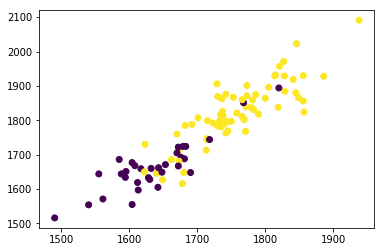

In [21]:
sub = people[:100]
plt.scatter(sub.stature, sub.span, c=sub.Gender.cat.codes);

You can add a cmap argument like ```cmap='copper'``` to change the colors. A [colormap](https://matplotlib.org/examples/color/colormaps_reference.html) maps a range of numeric values to a range of colors. I our case, we only have the values 0 and 1, so those get mapped to the extremes of the chosen colormap.

### Classification

Now let's try some actual machine learning on the data. 

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

train = people[:4000]
test  = people[4000:]
# NB: We can split like this because we know the data is shuffled

tree = DecisionTreeClassifier()
tree.fit(train[['stature','span']], train.Gender)

accuracy_score(tree.predict(test[['stature', 'span']]), test.Gender)

0.7857833655705996

As you can see, sklearn integrates beautifully with pandas, making our training and testing code even simpler. Not all libraries integrate this well with pandas; mlxtend, for instance, only inderstands numpy data.

Happily, pandas data contains numpy arrays in the background, and we can simply ask for those. On a single column, you can use ```.values``` to get a 1D numpy array. For multiple columns you can use ```.as_matrix()```.

/Users/Peter/anaconda/envs/pytorch4/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


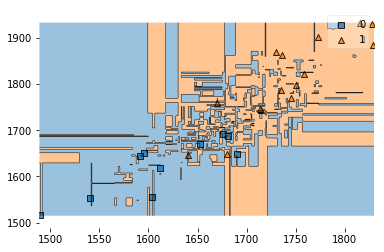

In [24]:
from mlxtend.plotting import plot_decision_regions

# Plot the decision boundary with the first 50 points in the test set
numpy_x = train[['stature','span']].as_matrix()
numpy_y = train.Gender.cat.codes.values

# This is necessary if pandas read the CSV files as integers
# (seems to depend on version/OS)
numpy_x = numpy_x.astype(float)

# Rebuild the classifier 
# (a classifier trained on pandas data doesn't interoperate well with pure numpy data)
tree = DecisionTreeClassifier()
tree.fit(numpy_x, numpy_y)

plot_decision_regions(numpy_x[:25, :], numpy_y[:25], clf=tree, res=0.1);



## Final comments

As usual, there is a lot more to learn. A good place to start is the 10-minute quicktstart guide to pandas:
https://pandas.pydata.org/pandas-docs/stable/10min.html

One very useful feature we didn't mention is _grouping_ (which will be familiar if you've done a little SQL):
https://pandas.pydata.org/pandas-docs/stable/groupby.html

Here's a list of 12 random tips, which gives you a good idea of how far pandas can go:
https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/

Next week, deep learning with _Keras_.